In [ ]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
from nltk.corpus import stopwords
import string
import numpy as np
import nltk
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.cross_validation import train_test_split
from nltk.classify.scikitlearn import SklearnClassifier
import unicodedata 
from sklearn.feature_selection.univariate_selection import SelectKBest, chi2
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud 
from nltk.corpus import stopwords
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets, svm
from nltk.corpus import wordnet as wn
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [9]:
#import data 

df = pd.read_csv("train.tsv",sep='\t' , encoding='utf-8', nrows= 20000 )
df_test =  pd.read_csv("test.tsv",sep='\t' , encoding='utf-8' )
df.drop(["PhraseId","SentenceId"],axis=1,inplace=True) # remove useless columns
df_test.drop(["PhraseId","SentenceId"],axis=1,inplace=True) # remove useless columns

df.shape

(20000, 2)

All frequencies, including STOPWORDS:
     Word  Frequency
0     the      51220
1       ,      42006
2       a      36123
3      of      32308
4     and      31763
5      to      22448
6       .      17865
7      's      16971
8      in      13745
9      is      13447
10   that      12327
11     it      11677
12     as       8623
13   with       7750
14    for       7417
15    its       7051
16   film       6689
17     an       6479
18  movie       5905
19   this       5677
20    but       5126
21     be       4977
22    you       4827
23     on       4730
24    n't       3970
25     by       3918
26   more       3888
27    his       3827
28  about       3682
29    one       3609


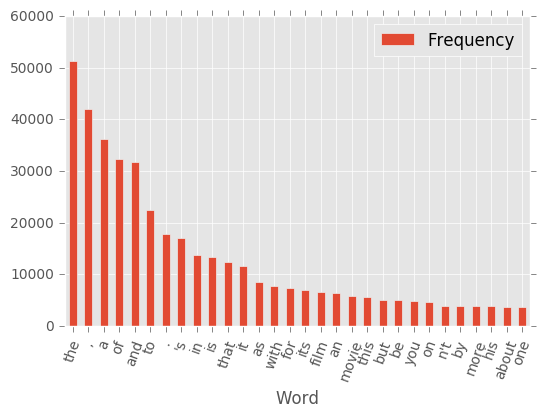

In [4]:
txt = df.Phrase.str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(txt)
word_dist = nltk.FreqDist(words)

stopwords = nltk.corpus.stopwords.words('english')
words_except_stop_dist = nltk.FreqDist(w for w in words if w not in stopwords) 

top_N = 30
print('All frequencies, including STOPWORDS:')
print('=' * 60)
rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency'])
print(rslt)
print('=' * 60)

rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')

plt.style.use('ggplot')

rslt.plot.bar(rot=70)
plt.show()

In [5]:
#number of tokens in the corpus
txt = df.Phrase.str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
wordss = nltk.tokenize.word_tokenize(txt)
len(wordss)

1124613

In [7]:
#number of stop words
stop = stopwords.words('english')
a = []
for w in wordss:

    if w in stop:
        a.append(w)
len(a)
        

414060

In [9]:
#number of english words
import enchant
b = []
d = enchant.Dict("en_US")
for word in wordss:
    if d.check(word):
        b.append(word)


c = []
for w in b:

    if w not in stop:
        c.append(w)
len(c)


581190

In [11]:
count = lambda l1, l2: len(list(filter(lambda c: c in l2, l1)))

a_chars =  count(wordss, string.ascii_letters)
a_punct = count(wordss, string.punctuation)

print a_chars
print a_punct

40467
67553


In [31]:
target = df.Sentiment.unique()

In [9]:
df.head()

,Phrase,Sentiment
0,A series of escapades demonstrating the adage ...,1
1,A series of escapades demonstrating the adage ...,2
2,A series,2
3,A,2
4,series,2


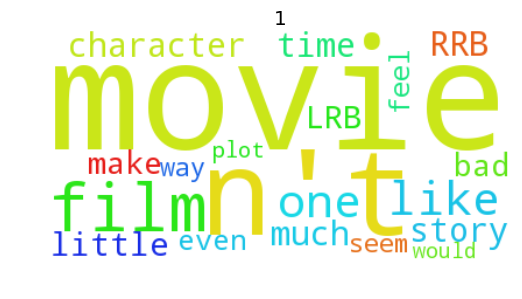

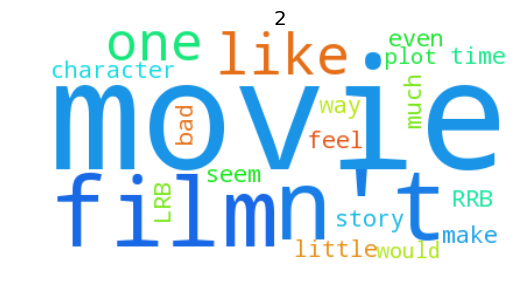

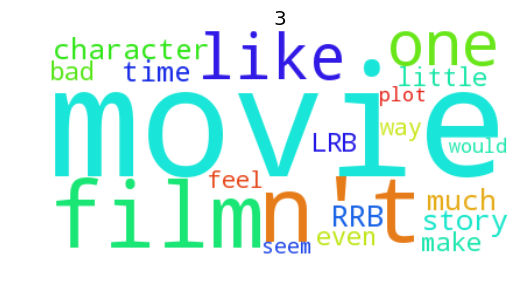

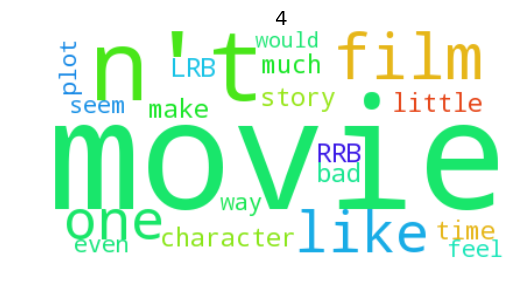

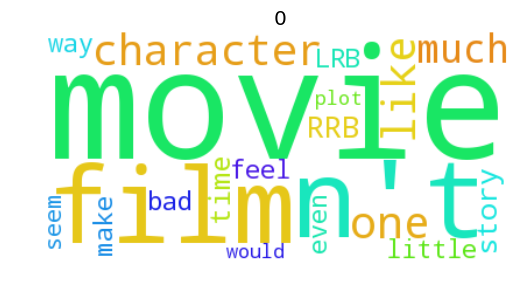

In [10]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
range = [1,2,3,4,0]
cloud = WordCloud(background_color="white", max_words=20, stopwords=stopwords.words('english'))
for i in range: 
    positive_cloud = cloud.generate(df.loc[df.Sentiment == 1, 'Phrase'].str.cat(sep='\n'))
    plt.figure()
    plt.imshow(positive_cloud)
    plt.axis("off")
    plt.title(i)
    plt.show()

In [10]:
# Transformer des caractères spéciaux en ASCII + maj to minuscules ( sorte de normalisation)
df['Phrase'] = (df['Phrase'].str.lower()
              .str.decode('utf-8')
              .map(lambda x: unicodedata.normalize('NFKD', x))
              .str.encode('ascii', 'ignore'))



 1) Remove punctuation marks and transform all characters to lowercase using nlk library 2) Remove stop words 3) Steaming

Sans oublier la segmentation afin de separer chaque phrase en mot l idée c que chaque mot dans une phrase va être consideré comme étant un feature
and finally tfidf

In [11]:
#stop words
stop = stopwords.words('english')
stop.extend(['will','now','today','movie','serie','series','story','film'])

# remove punctionation

def remove_punctuation(s):
    s = ''.join([i for i in s if i not in set(string.punctuation)])
    return s

df['Phrase'] = df['Phrase'].apply(remove_punctuation)
#stemming
stemmer = PorterStemmer()
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed
#lemmatisation
lmtzr = WordNetLemmatizer()
def lem_tokens(tokens, lmtzr):
    tokked = []
    for item in tokens:
        tokked.append(lmtzr.lemmatize(item))
    return tokked

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    tokens = lem_tokens (stems,lmtzr)
    return stems

In [150]:
#df['Phrase'] = df['Phrase'].apply(tokenize)

In [151]:
#df['Phrase'] = df['Phrase'].apply(lambda x: [item for item in x if item not in stop])

In [121]:
#delete empty rows

#df['Phrase'] = df[df.Phrase.map(lambda x: len(x) if isinstance(x, list) else None) != 0]
#df = df.dropna()

In [152]:
#transform a list to one string

#df['Phrase'] = df.Phrase.map(lambda x: ' '.join(x))

In [124]:
#remove duplicates rows because after pre-processing we get same occurences

#df = df.drop_duplicates()

In [12]:
# we can improve it with changing parameters and add other parametrs 
# for example ngrams 
# max_df , min_df  and max_feature
#,ngram_range = (1,2)
vect = TfidfVectorizer(min_df=5,sublinear_tf=True, analyzer='word', stop_words=stop, tokenizer=tokenize , strip_accents = 'ascii',  max_df = 0.8,ngram_range = (1,2))

In [13]:
#  if it takes time
transform = vect.fit_transform(df.pop('Phrase'))

In [14]:
# save it because it takes time in order to execute the same operation each time
import pickle
pickle.dump(transform, open("vectorizer.pickle", "wb"))

In [15]:
X = pickle.load(open(("vectorizer.pickle"), "rb"))

In [16]:
#sparse matrix to datframe here i used a loop because the memory of my computer does not suppert #to transfor matrix to dataframe en un seul coup that why it take time 
for i, col in enumerate(vect.get_feature_names()):
    df[col] = pd.SparseSeries(X[:, i].toarray().reshape(-1,), fill_value=0)

In [125]:
#df.to_csv('dfidf.csv', sep='\t', encoding='utf-8')

In [157]:
df.shape

(30000, 4368)

In [30]:
df.head()

,Sentiment,1,10,10 minut,100,100 minut,10thgrade,10thgrade learn,120,12yearold,...,zeal squeez,zelda,zelda ultim,zemecki,zemecki agre,zinger,zip,zone,zone bale,zone ordin
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
for i, col in enumerate(vect.get_feature_names()):
    df_test[col] = pd.SparseSeries(X[:, i].toarray().reshape(-1,), fill_value=0)

In [22]:
#test if there are any NaN
print(df.isnull().values.sum().sum())


0


In [21]:
df.isnull().values.any()

False

In [19]:
#label = df.Sentiment
#train= df.drop('Sentiment', axis=1)

In [20]:
#pipline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


# create pipeline
estimators = []

estimators.append(('features', SelectKBest(chi2, k = 1)))

estimators.append(('classif',  LinearSVC(C= 10)))

model = Pipeline(estimators)
# evaluate pipeline
seed = 7
kfold = KFold(n_splits=5, random_state=seed)
results = cross_val_score(model, train, label, cv=kfold)
print(results.mean())


0.5515


In [17]:
data_frame = df.values
train = data_frame[:,1:]
label = data_frame[:,0]

In [18]:
#pipline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import sklearn.grid_search

# create pipeline
estimators = []

estimators.append(('features', SelectKBest(chi2)))
estimators.append(('classif', MultinomialNB()))

model = Pipeline(estimators)
# evaluate pipeline
parameters = dict(features__k=[1000,2000,4000,5000], 
              classif__alpha=[0.1,1,10,100,1000])
                  
cv = sklearn.grid_search.GridSearchCV(model, param_grid=parameters)
cv.fit(train,label)


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('features', SelectKBest(k=10, score_func=<function chi2 at 0x7f0a6e238668>)), ('classif', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'features__k': [1000, 2000, 4000, 5000], 'classif__alpha': [0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [19]:
# View the accuracy score
#print('Best score for data1:', cv.best_score_)
# View the best parameters for the model found using grid search
#print('Best C:',cv.featurC)
print('best parameters:',cv.best_params_)


('best parameters:', {'features__k': 1000, 'classif__alpha': 10})


In [39]:
df.head()

,Sentiment,!,',' :,' achiev,' actor,' doe,' first,' ha,' live,...,young,young actress,young ballesta,young fit,young romant,youth,youth remain,zaza,zinger,zip
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
#with k = 5000 the number of feature ( not sure if it correct or not)
fselect = SelectKBest(chi2, k=1)
fit = fselect.fit_transform(train, label)
# summarize scores


In [ ]:
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train) 


In [ ]:
k_score = []
erreur = []
log_var = np.logspace(-2,0,10)
for c in log_var:
    clf = svm.SVC(kernel='linear', C=c)
    clf.fit(X_train, y_train) 
    print("score d'entrainement: for"  , str(c) , clf.score(X_train, y_train))
    erreur.append(clf.score(X_train, y_train))
    
    #decision boundary 
    
    plot_boundary(clf,X_train, y_train)
    plt.title('C = ' + str(c))
    plt.show()
    
    pred = clf.predict(X_test)
    print("score test is  for"  , str(c)  )
    score = accuracy_score(y_test, pred)
    print ( score )
    k_score.append(score)

In [ ]:
plt.plot(log_var, k_score)
plt.xlabel ('c')
plt.ylabel('score ')


plt.plot(log_var, erreur)
plt.xlabel ('c')
plt.ylabel('score')

plt.legend(['y = test', 'y = apprentisage' ], loc='lower right')
plt.show()

In [ ]:
#grid search to find the best parameters


In [ ]:
#pd.SparseDataFrame(X.todense(), columns=vect.get_feature_names(), index=df.index) 

In [253]:
#X = vect.fit_transform(df.pop('Phrase'))
#X = vect.fit_transform(df.pop('Phrase')).toarray()

#for i, col in enumerate(vect.get_feature_names()):
    #df[col] = X[:, i]

In [90]:
#r = df[['Sentiment']].copy()
#del df
#d = pd.DataFrame(X.toarray(), columns=vect.get_feature_names(), iterator=True, chunksize=10)

#d = pd.DataFrame(X, columns=vect.get_feature_names())
#del X
#del vect



In [200]:
classif = SklearnClassifier(LinearSVC())
# Séparation du set de train et de test
X_train,X_test,y_train,y_test = train_test_split(train,label, test_size = 0.33)


In [168]:
X_train.shape

(13400, 8486)

In [ ]:
#without feature selection and without ngram
from sklearn.naive_bayes import BernoulliNB
clf = svm.SVC(decision_function_shape='ovo')
clf = clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print a
score = accuracy_score(y_test, pred)
print score 

In [203]:
np.unique(pred)

array([2])

In [185]:
np.unique(y_test)

array([0, 1, 2, 3, 4])

In [186]:
pred

array([1, 0, 0, ..., 0, 0, 3])

In [187]:
y_test

array([2, 4, 2, ..., 2, 4, 2])

Confusion matrix, without normalization
[[ 288    6    0    0    0]
 [1139   60   57    5    0]
 [3275  101  822  183   16]
 [1403   12   75   88   34]
 [ 395    2    5   19   15]]
Normalized confusion matrix
[[ 0.98  0.02  0.    0.    0.  ]
 [ 0.9   0.05  0.05  0.    0.  ]
 [ 0.74  0.02  0.19  0.04  0.  ]
 [ 0.87  0.01  0.05  0.05  0.02]
 [ 0.91  0.    0.01  0.04  0.03]]


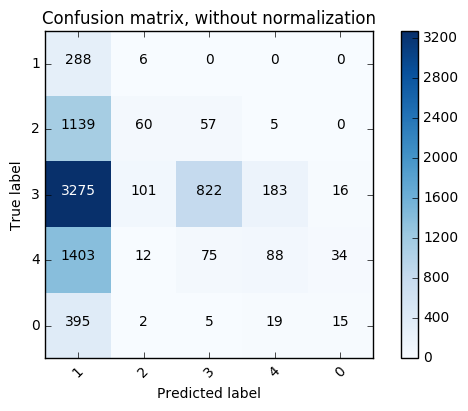

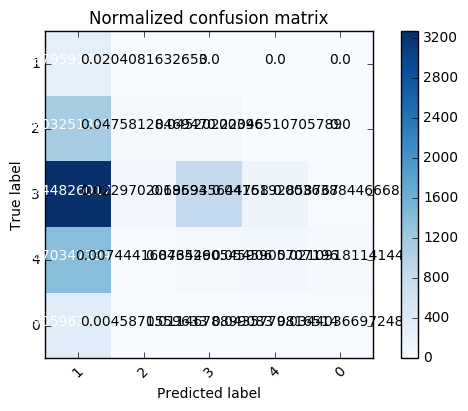

In [188]:
import itertools
class_names = target
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, pred)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()




[[   0    0  140    0    0]
 [   0    0  647    0    0]
 [   0    0 2227    0    0]
 [   0    0  764    0    0]
 [   0    0  222    0    0]]


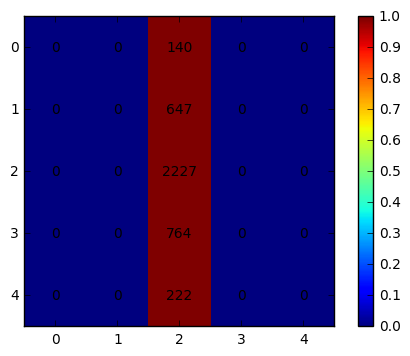

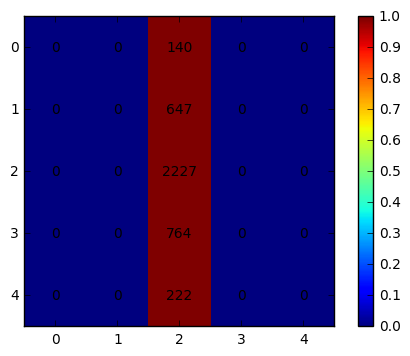

In [32]:
conf_arr= confusion_matrix(y_test, pred)
print conf
norm_conf = []
for i in conf_arr:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_conf.append(tmp_arr)

fig = plt.figure()
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=plt.cm.jet, 
                interpolation='nearest')

width, height = conf_arr.shape

for x in xrange(width):
    for y in xrange(height):
        ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

cb = fig.colorbar(res)

plt.xticks(target)
plt.yticks(target)
plt.show()
plt.savefig('confusion_matrix.png', format='png')

In [150]:
#with feature selection and without ngram
from sklearn.naive_bayes import BernoulliNB
gnb = BernoulliNB()
clf = gnb.fit(X_train, y_train)
pred = clf.predict(X_test)
a = clf.score(X_train, y_train)
print a
score = accuracy_score(y_test, pred)
print score 

0.558705882353
0.552


In [154]:
np.unique(pred)


array([2, 3])

[[   0    9  221    1    0]
 [   0   28  936    2    0]
 [   0   31 3153   49    0]
 [   0    0 1208   52    0]
 [   0    0  297   13    0]]


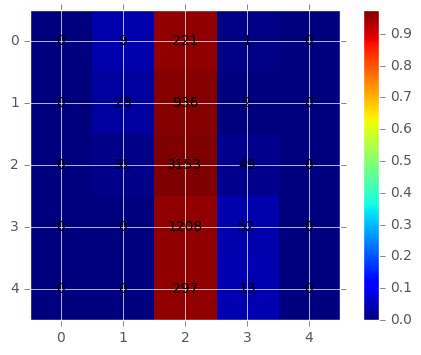

[[   0    7  224    0    0]
 [   0   27  903    2    0]
 [   0   39 3233   25    0]
 [   0    1 1183   56    0]
 [   0    0  286   14    0]]


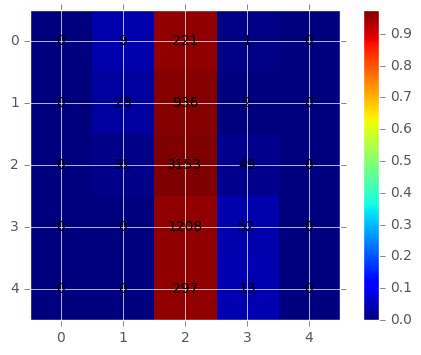

In [232]:
#confusion matrix 

conf_arr= confusion_matrix(y_test, pred)
print conf_arr
norm_conf = []
for i in conf_arr:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_conf.append(tmp_arr)

fig = plt.figure()
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=plt.cm.jet, 
                interpolation='nearest')

width, height = conf_arr.shape

for x in xrange(width):
    for y in xrange(height):
        ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

cb = fig.colorbar(res)

plt.xticks(target)
plt.yticks(target)
plt.show()

print conf
norm_conf = []
for i in conf_arr:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_conf.append(tmp_arr)

fig = plt.figure()
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=plt.cm.jet, 
                interpolation='nearest')

width, height = conf_arr.shape

for x in xrange(width):
    for y in xrange(height):
        ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

cb = fig.colorbar(res)

plt.xticks(target)
plt.yticks(target)
plt.show()


In [128]:
without feature selection and ngram

good = 0
print(len(y_test))
ln=len(y_test)
for i in y_test:
    if(y_test[i] == y_pred[i]):
        good= good+1
print("BernoulliNB accuracy:", good*100/len(y_test))

2000
('BernoulliNB accuracy:', 79)


In [139]:
with feature selection and ngram

good = 0
print(len(y_test))
ln=len(y_test)
for i in y_test:
    if(y_test[i] == pred[i]):
        good= good+1
print("BernoulliNB accuracy:", good*100/len(y_test))

6000
('BernoulliNB accuracy:', 80)


8000
('BernoulliNB accuracy:', 80)
